In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import choice, seed, normal
from numpy import sqrt, exp, log
from scipy.stats import norm
import pandas as pd

In [2]:
symmetric_random_walk = lambda nsteps: np.cumsum(np.append(0, choice([-1,1], nsteps)))
scaled_random_walk  = lambda partitions, t: symmetric_random_walk(partitions * t) / sqrt(partitions)

## Payoff of a forward

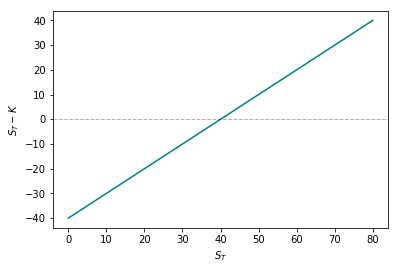

In [21]:
X = np.linspace(0, 80, 25)
fwd = lambda s, k: s - k
Y = [fwd(s, 40) for s in X]

plt.plot(X, Y, color="teal")
plt.axhline(y=0, alpha=0.3, color="K", linestyle="dashed", linewidth=1)
plt.ylabel(r"$S_T - K$")
plt.xlabel(r"$S_T$")
plt.savefig("../images/foward_payoff.pdf")
plt.show()

## Payoff of a call option

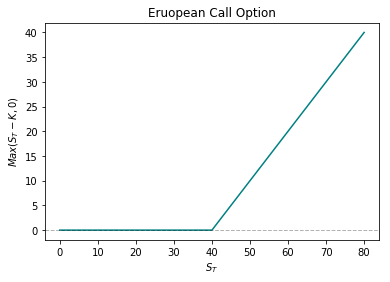

In [22]:
X = np.linspace(0, 80, 25)
call = lambda s, k: max(s - k, 0)
Y = [call(x, 40) for x in X]

plt.plot(X, Y, color="teal")
plt.axhline(y=0, alpha=0.3, color="K", linestyle="dashed", linewidth=1)
plt.ylabel(r"$Max(S_T - K, 0)$")
plt.xlabel(r"$S_T$")
plt.title("Eruopean Call Option")
plt.savefig("../images/Call.pdf")
plt.show()

## Symmetric Random Walk

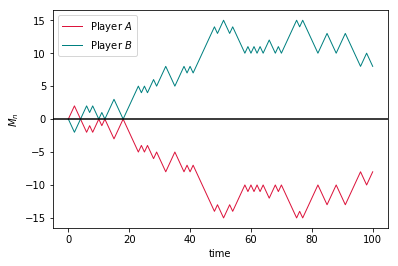

In [10]:
seed(1643)
rwalk_sample = symmetric_random_walk(100)
plt.plot(rwalk_sample, label="Player $A$", linewidth=1, c="crimson")
plt.plot(-rwalk_sample, label="Player $B$", linewidth=1, c="teal")
plt.axhline(y=0, xmin=0, xmax=100, color="black")
plt.xlabel("time")
plt.ylabel("$M_n$")
plt.legend(loc="best")
plt.savefig("../images/symmetric_random_walk.pdf")
plt.show()

## Scaled Random Walk

In [10]:
seed(1643)

breaks = 1000
RW = pd.DataFrame()
partitions = [1, 10, 20, 500]

rw = scaled_random_walk(breaks, 1)
for partition in partitions:
    new_scale = int(breaks / partition)
    rw_new = scaled_random_walk(new_scale, 1)
    rw_new_rows = np.array([i * partition for i in range(new_scale + 1)])
    
    RW.ix[rw_new_rows, "N = {}".format(new_scale)] = rw_new
    
RW.index = np.linspace(0, 1, breaks + 1)
RW.ffill(inplace=True)

/Users/gerardoduran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


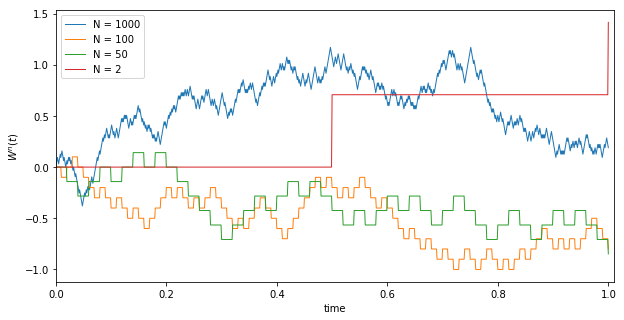

In [11]:
RW.plot(linewidth=1, figsize=(10,5))
plt.xlabel("time")
plt.ylabel("$W^n(t)$")
plt.xlim(0, 1.01);
plt.savefig("../images/scaled_random_walk.pdf")
plt.show()

## Distribution of a Symmetric random walk as n tends to infinity 

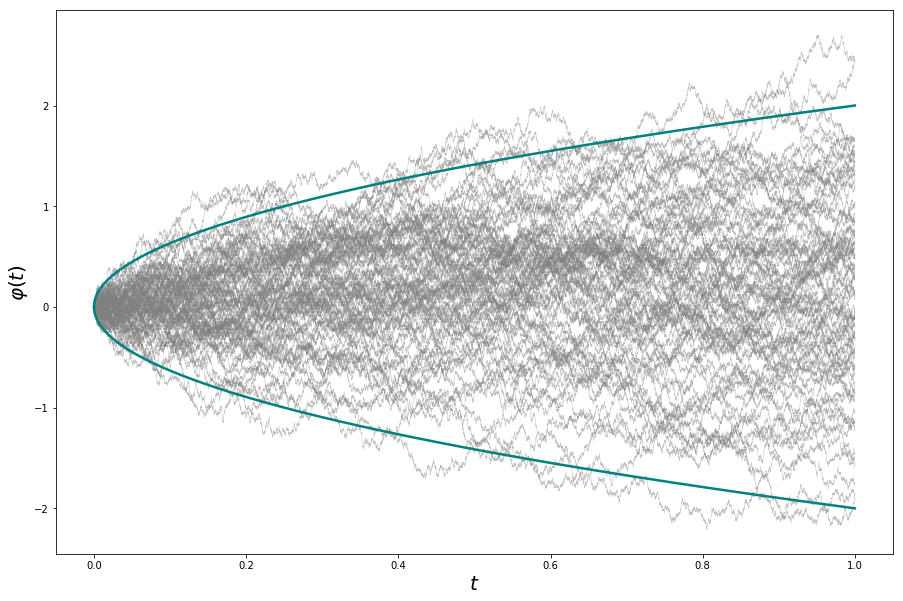

In [9]:
seed(1707)
partitions = 5000
plt.figure(figsize=(15,10))
for i in range(80):
    x = np.linspace(0, 1, partitions+1)
    wn = scaled_random_walk(partitions, 1)
    plt.plot(x, wn, linewidth=0.5, alpha=0.5, color="gray")
    
plt.plot(x, 2*np.sqrt(x), color="teal", linewidth=2.5)
plt.plot(x, -2*np.sqrt(x), color="teal", linewidth=2.5)
plt.xlabel("$t$", fontsize=20)
plt.ylabel(r"$\varphi(t)$", fontsize=20)
plt.savefig("../images/bm.pdf")
plt.show()

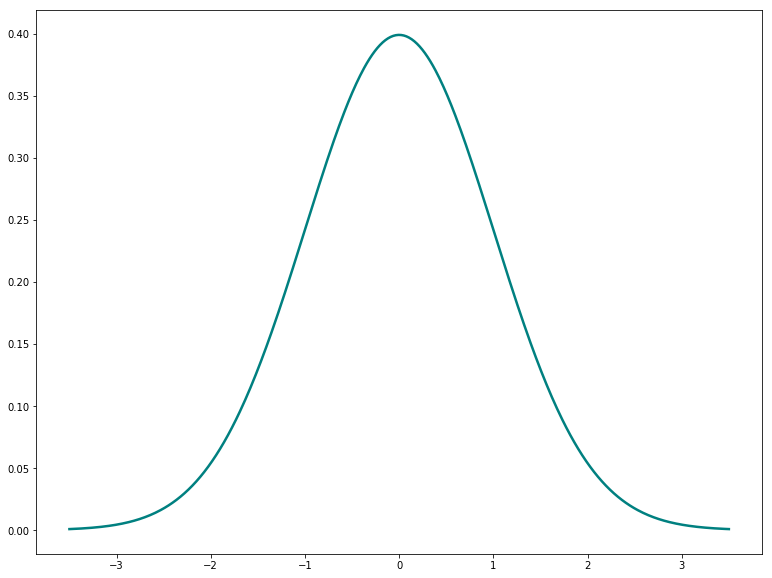

In [7]:
plt.figure(figsize=(13,10))
x = np.linspace(-3.5, 3.5, 500)
plt.plot(x, norm.pdf(x), c="teal", linewidth=2.5)
plt.savefig("../images/normal_distribution.pdf")
plt.show()

# Simple Process

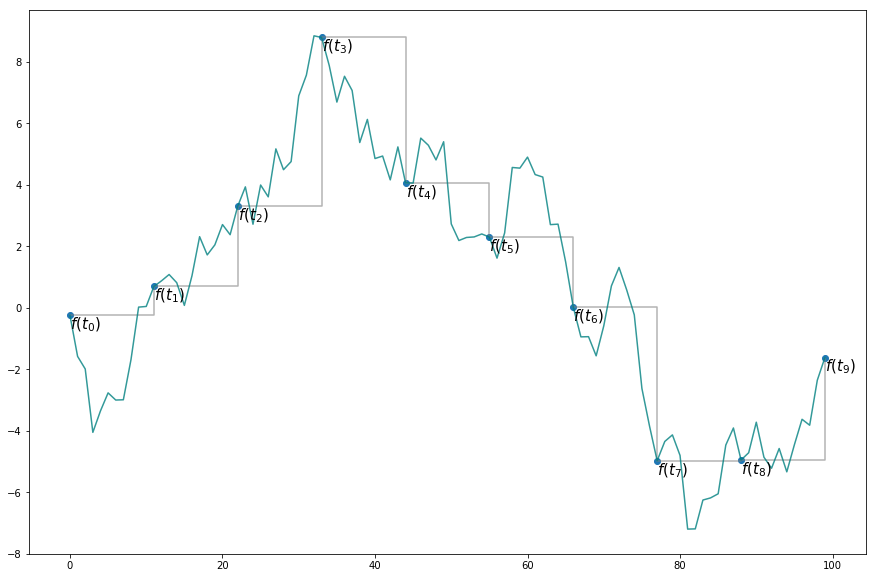

In [57]:
seed(1983)
plt.figure(figsize=(15,10))
values = normal(size=100).cumsum()

from math import ceil
def partition_process(process, nparts):
    steps = ceil(len(process) / nparts) - 1
    partition_process = []
    indices = [steps * i for i in range(nparts+1)]
    for ix in indices:
        partition_process.append(process[ix])
    
    return indices, partition_process

for i in [9]:
    data = partition_process(values, i)
    plt.step(*data, alpha=0.6, where="post", color="gray")
    plt.scatter(*data)
    
    for ix, (x, y) in enumerate(zip(*data)):
        plt.text(x, y, "$f(t_{})$".format(ix),
                 fontsize=15, verticalalignment="top")
        
plt.plot(values, color="teal", alpha=0.8)

#plt.savefig("../images/simple_process.pdf")
plt.show()

# Stock Dynamics

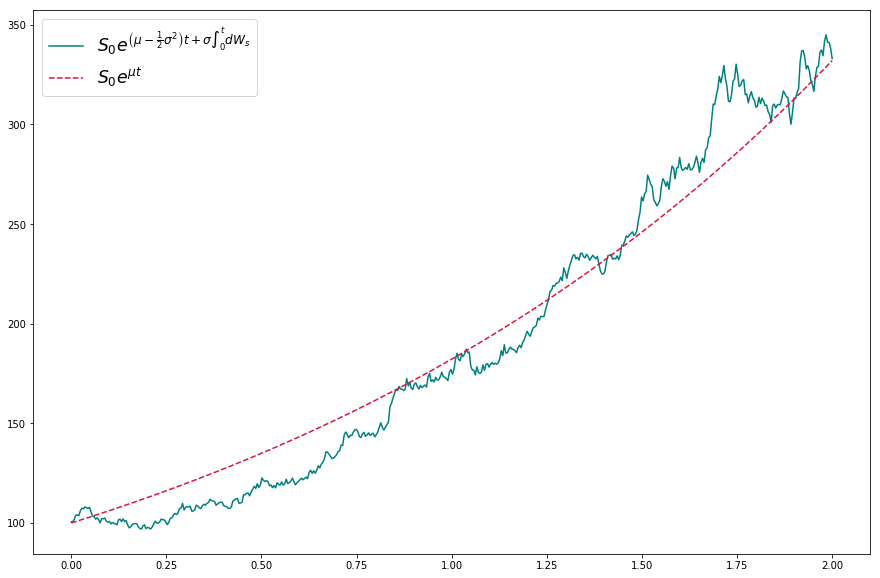

In [3]:
seed(42)

S0 = 100
mu = 0.6
sigma = 0.2
steps, T = 500, 2
t = np.linspace(0, T, steps)
Wt = normal(scale=np.sqrt(T/steps), size=steps).cumsum()


St = S0 * np.exp((mu - sigma ** 2 / 2) * t + sigma * Wt)
Yt = S0 * np.exp(mu * t)

plt.figure(figsize=(15,10))
plt.plot(t, St, color="teal", label=r"$S_0e^{\left(\mu - \frac{1}{2}\sigma^2\right) t + \sigma\int_0^t dW_s}$")
plt.plot(t, Yt, "--", color="crimson", label=r"$S_0e^{\mu t}$")
plt.legend(fontsize="xx-large")

plt.savefig("../images/asset_sde.pdf")
plt.show()

# Montecarlo Pricing

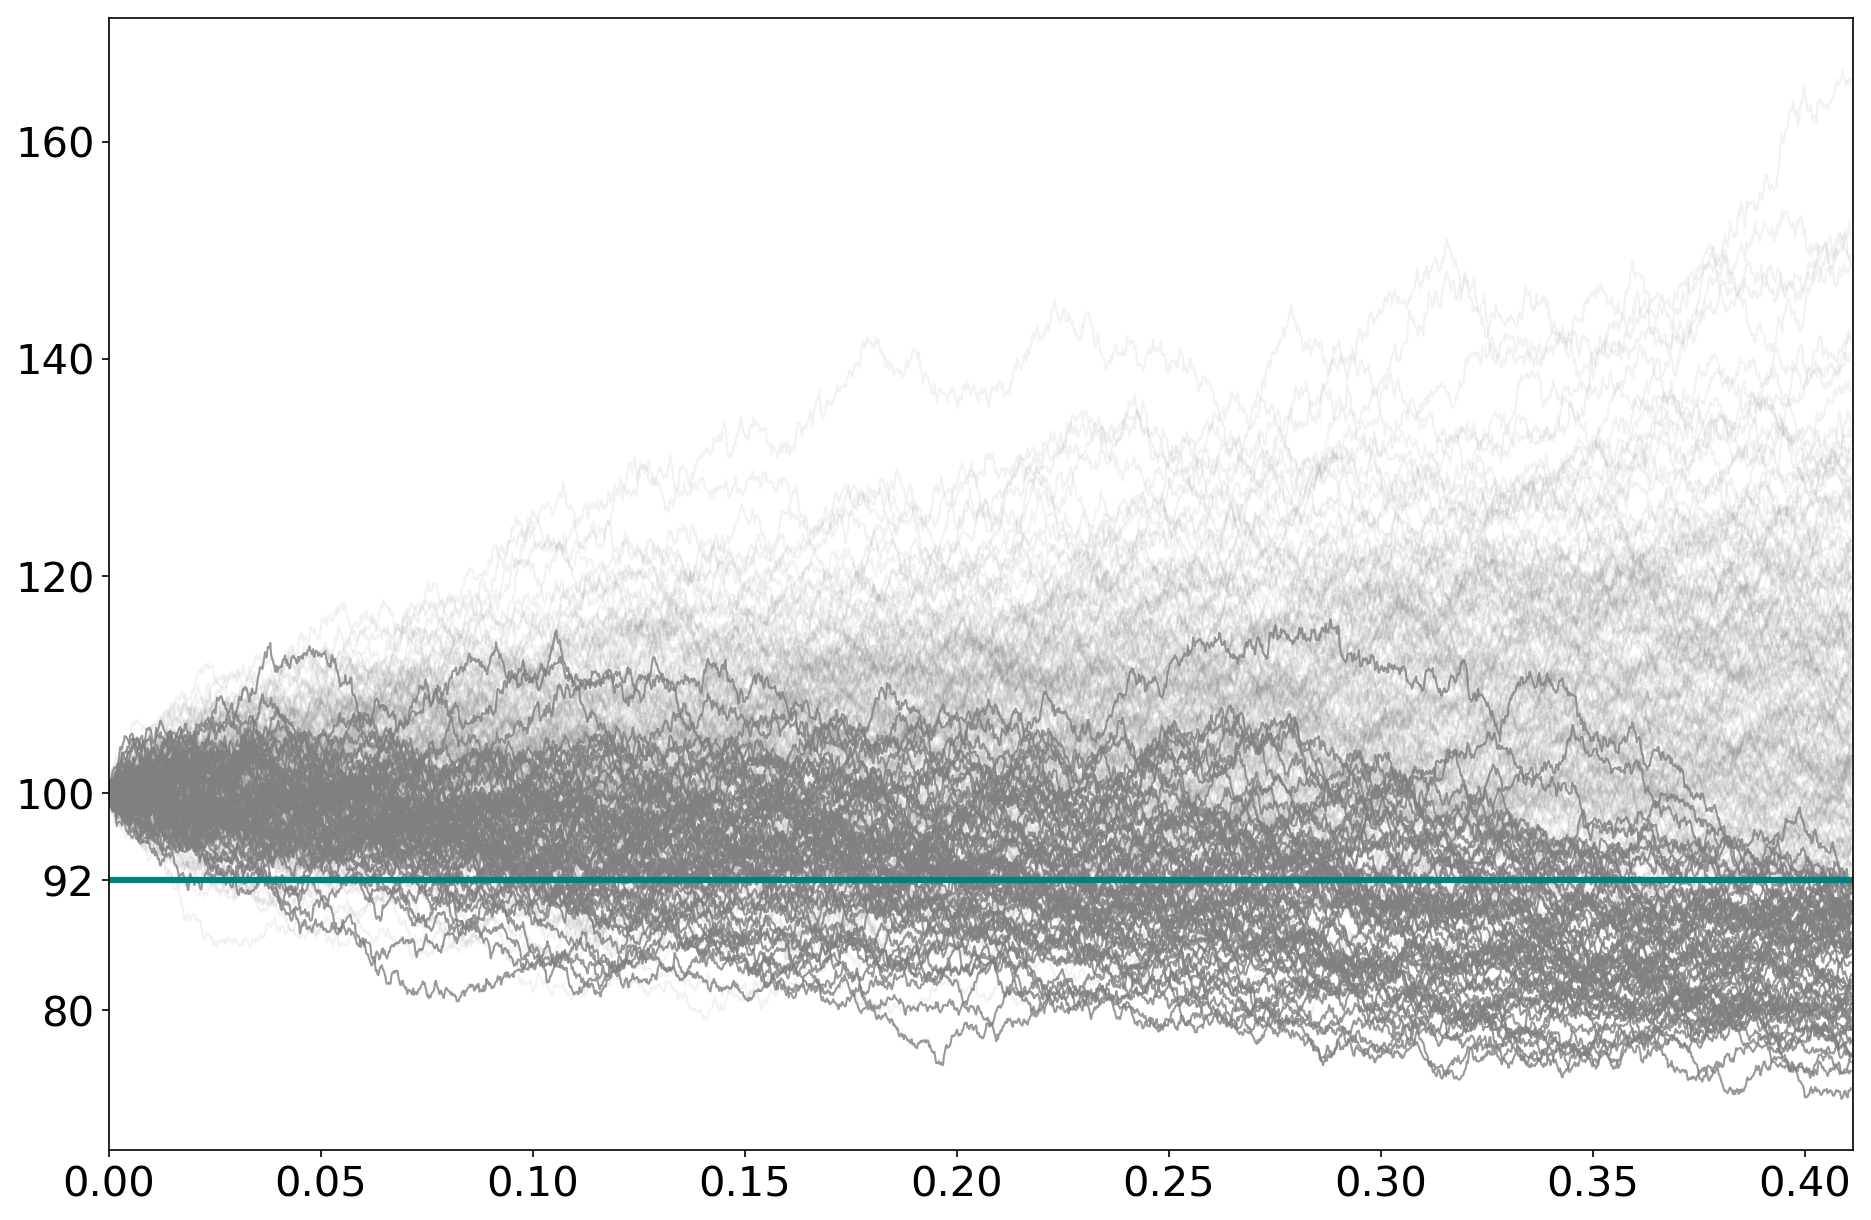

In [13]:
seed(3141592)

S0 = 100
K = 92
r = 0.06
sigma = 0.23
T = 150 / 365

steps = 2000
t = np.linspace(0, T, steps)
delta_t = T / steps

plt.figure(figsize=(15,10), dpi=150)
for i in range(250):
    Wt  = normal(scale=sqrt(delta_t), size=steps).cumsum()
    St = S0 * exp(sigma * Wt + (r - sigma ** 2 / 2) * t)
    if St[-1] < K :
        plt.plot(t, St, linewidth=1, color="gray", alpha=0.8)
    else:
        plt.plot(t, St, linewidth=1, color="gray", alpha=0.1)

plt.xlim(0, T * 1.001)
plt.axhline(y=K, color="teal", linewidth=3)
plt.xticks(fontsize=20)
yticks = [K, 80, 100, 120, 140, 160]; yticks.sort()
plt.yticks(yticks, fontsize=20)


plt.savefig("../images/european_call_montecarlo.pdf")
plt.show()

## Span of solutions for the trinomial model

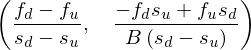

In [106]:
from sympy import symbols, init_printing, solve 
from sympy.printing import latex
init_printing()

su, sd, sm = symbols("s_u s_d s_m")
phi, psi = symbols("phi psi")
fu, fd, fm = symbols("f_u f_d f_m")
B = symbols("B")

phi_s, psi_s = solve((su * phi + B * psi - fu,
                      sd * phi + B * psi - fd), (phi, psi)).values()
phi_s, psi_s

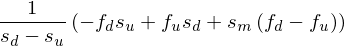

In [107]:
(phi_s * sm + psi_s * B).simplify()

In [87]:
r = 0.03
k = 100
B = np.exp(-r)
sd, sm, su = np.linspace(99, 119, 500), np.linspace(100, 120, 500), np.linspace(101, 121, 500)
fd, fu = np.maximum(sd - k, 0), np.maximum(su - k, 0)

fd, fu = np.meshgrid(fd, fu)
sd, su = np.meshgrid(sd, su)

fm = (-fd * su + fu * sd + sm * (fd - fu)) / (sd - su)

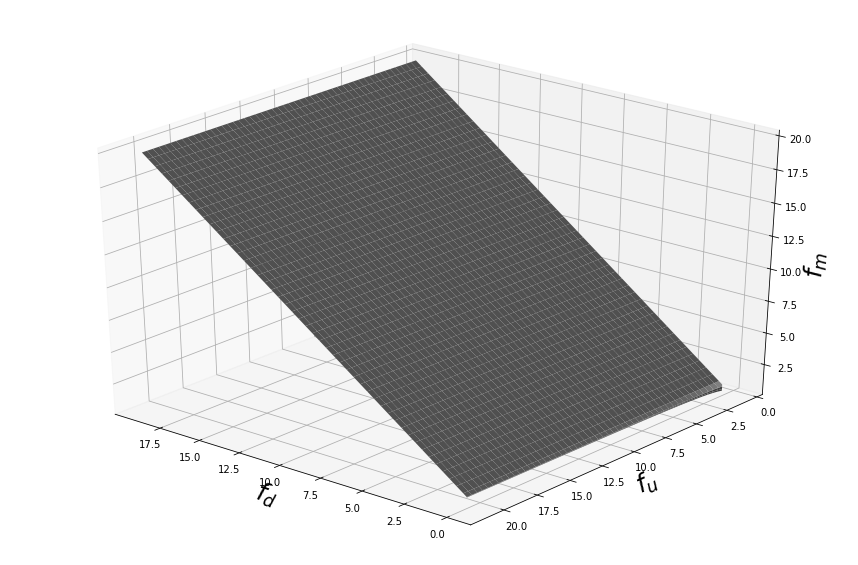

In [100]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.plot_surface(fd, fu, fm, color="gray")
ax.set_xlabel("$f_d$", size=25)
ax.set_ylabel("$f_u$", size=25)
ax.set_zlabel("$f_m$", size=25)
ax.view_init(30, 130)
plt.savefig("../images/trinomial_sol.pdf")
plt.show()